In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras_tuner as kt
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from pyts.image import GramianAngularField

## Step 1 ##

Let us consider the stock Asian Paints, which is traded on the Indian stock markets. We download the data from yfinance for the past 8 years.

In [4]:
data = yf.Ticker("ASIANPAINT.NS").history(period="8y")

In [5]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-27 00:00:00+05:30,953.300900,961.370911,942.918415,945.702820,738246,0.0,0.0
2017-02-28 00:00:00+05:30,946.788084,969.157686,942.116013,966.703552,1368244,0.0,0.0
2017-03-01 00:00:00+05:30,972.177939,981.616560,968.449730,974.773560,1124115,0.0,0.0
2017-03-02 00:00:00+05:30,979.634838,986.100273,968.780420,970.998474,1037442,0.0,0.0
2017-03-03 00:00:00+05:30,969.393747,969.393747,949.525401,956.793152,596208,0.0,0.0


In [6]:
data.shape #less than 2000 rows of data, as stated in the GWP

(1976, 7)

For the analysis that follows, we consider just the closing price

In [8]:
data = data["Close"]
data.head()

Date
2017-02-27 00:00:00+05:30    945.702820
2017-02-28 00:00:00+05:30    966.703552
2017-03-01 00:00:00+05:30    974.773560
2017-03-02 00:00:00+05:30    970.998474
2017-03-03 00:00:00+05:30    956.793152
Name: Close, dtype: float64

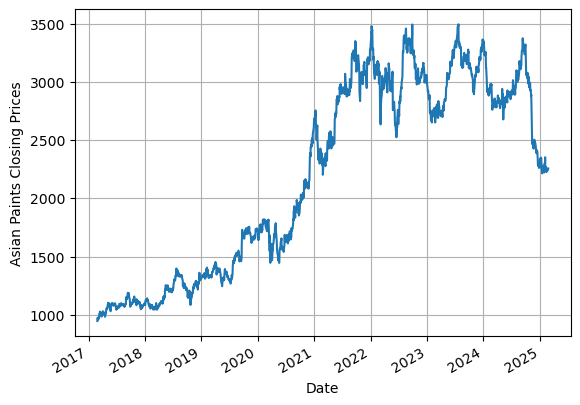

In [9]:
#Plot the time series
data.plot(ylabel="Asian Paints Closing Prices")
plt.grid()

The plot clearly shows a trend in the time series. The prices of the Asian Paints stock clearly rises with time.

In [11]:
data.describe() #summary statistics for the untransformed time series

count    1976.000000
mean     2198.298583
std       825.730210
min       945.702820
25%      1332.738129
50%      2325.289062
75%      2987.162354
max      3497.630127
Name: Close, dtype: float64

Note that the series has a high standard deviation of 827.44, and a mean of 2196.67.

Text(0.5, 1.0, 'Histogram of Asian Paints Closing Price')

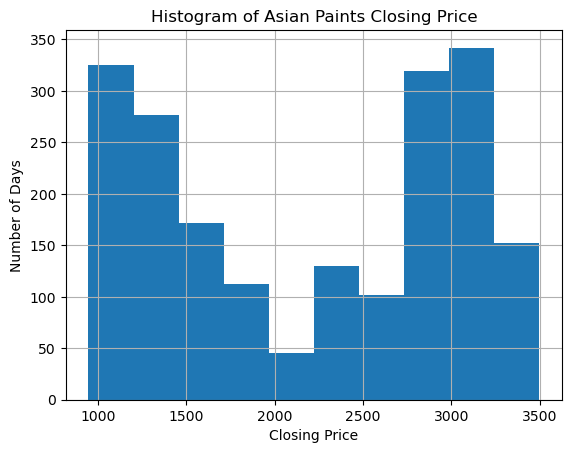

In [13]:
data.hist(bins = 10)
plt.xlabel("Closing Price")
plt.ylabel("Number of Days")
plt.title("Histogram of Asian Paints Closing Price")

Let us check for the presence of autocorrelation in the time series with different lags

In [15]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(data.autocorr(lag = i))

0.9991024517942791
0.9951754942036695
0.9904767008503962
0.9482131675979084
0.9135770685934598
0.8838146792453857
0.6505426424514977
-0.37311904722165296


As you can see, the time series is heavily autocorrelated

Let us test for stationarity using the Augmented Dickey-Fuller test

In [18]:
adf_result_data = adfuller(data)
adf_statistic = adf_result_data[0] 
p_value = adf_result_data[1]
used_lags = adf_result_data[2] 
critical_values = adf_result_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.5498126765152338,
 0.508741765271802,
 1,
 {'1%': -3.43366703339965,
  '5%': -2.8630052761696607,
  '10%': -2.567550052177805})

Note that the adf_statistic of -1.57 is higher than all the critical values. The p-value is 0.49 which is greater than 0.05. This means that we fail to reject the null hypothesis (that the series has a unit root). So, the untransformed time series for the Asian Paints NSE stock can be said be non-stationary.

In [20]:
differenced_data = data.diff()[1:]

In [21]:
differenced_data.head()

Date
2017-02-28 00:00:00+05:30    21.000732
2017-03-01 00:00:00+05:30     8.070007
2017-03-02 00:00:00+05:30    -3.775085
2017-03-03 00:00:00+05:30   -14.205322
2017-03-06 00:00:00+05:30    14.818726
Name: Close, dtype: float64

Text(0, 0.5, 'Differenced Prices [Lag 1]')

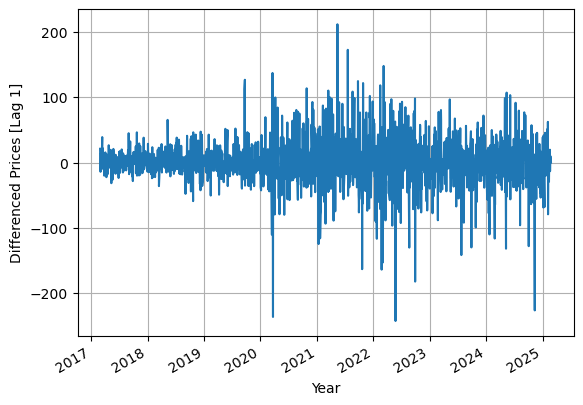

In [22]:
differenced_data.plot()
plt.grid()
plt.xlabel("Year")
plt.ylabel("Differenced Prices [Lag 1]")

In [23]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(differenced_data.autocorr(lag = i))

0.048358598408439445
-0.01393378713557292
0.001419079589778465
-0.062002459273083885
-0.0631558633405372
0.004070551021707361
-0.014467254089564075
0.020581335200034443


In [24]:
differenced_data.describe()

count    1975.000000
mean        0.664277
std        34.986949
min      -242.193359
25%       -13.613831
50%         0.429443
75%        15.966919
max       211.207275
Name: Close, dtype: float64

The differenced time series seems to be de-trended now. Let us now test for stationarity.

In [26]:
adf_result_differenced_data = adfuller(differenced_data)
adf_statistic = adf_result_differenced_data[0] 
p_value = adf_result_differenced_data[1]
used_lags = adf_result_differenced_data[2] 
critical_values = adf_result_differenced_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-42.31304018971308,
 0.0,
 0,
 {'1%': -3.43366703339965,
  '5%': -2.8630052761696607,
  '10%': -2.567550052177805})

Here, note that the p value is zero and the adf_statistic of -42.31 is lesser than all the critical values, which implies that the differenced time series is stationary.

Now, let us attempt to implement fractional differencing

In [29]:
def getWeights(d,lags):
    # calculate the weights from the series expansion of the differencing operator
    # for real orders d and up to [lags] number of coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

In [30]:
def fractional_differencing(series, order, cutoff):
    #calculate the time series obtained from fractional differencing
    weights=getWeights(order, cutoff)
    frac_diff_series = 0
    for k in range(cutoff):
        frac_diff_series += weights[k]*series.shift(k).fillna(0)
    return frac_diff_series[cutoff:] 

In [31]:
frac_diff_series = fractional_differencing(data, 0.75, 10) #considering d = 0.75 for now and we consider 10 terms in the series

Text(0, 0.5, 'Series After Fractional Differencing with d = 0.75')

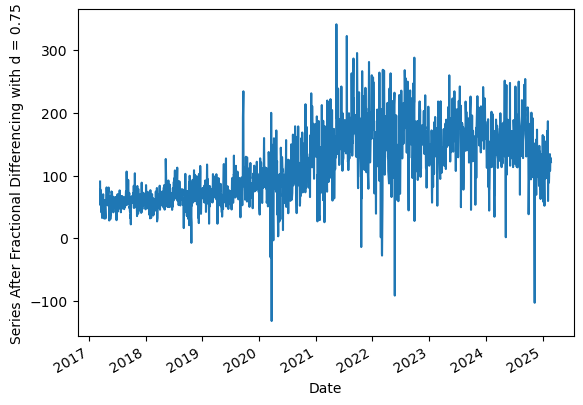

In [32]:
frac_diff_series.plot()
plt.ylabel("Series After Fractional Differencing with d = 0.75")

In [33]:
frac_diff_series.describe()

count    1966.000000
mean      116.722471
std        55.719545
min      -131.675934
25%        68.735003
50%       111.753474
75%       159.613799
max       340.877670
Name: Close, dtype: float64

In [34]:
adf_result_frac_diff_data = adfuller(frac_diff_series)
adf_statistic = adf_result_frac_diff_data[0] 
p_value = adf_result_frac_diff_data[1]
used_lags = adf_result_frac_diff_data[2] 
critical_values = adf_result_frac_diff_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-2.153893802882957,
 0.22340261518495286,
 26,
 {'1%': -3.433726987192922,
  '5%': -2.863031745358185,
  '10%': -2.5675641457890093})

Note that for this fractional differenced series with d = 0.75, the adf_statistic is higher than the critical values. The p-value of 0.22 also indicates that this fractional differenced series is not stationary.

## Step 2 

Let us now build Multi-Layer Perceptron models to predict the future values of these time series. Specifically, we predict if the stock will rise or fall the next day.

**First, the original time series.** he inputs to this model will be the returns over the past 10, 60, 150 days along with the present value.

In [39]:
data = data.to_frame()

In [40]:
data["1d_returns"] = data.pct_change()

In [41]:
data.head()

,Close,1d_returns
Date,,
2017-02-27 00:00:00+05:30,945.702820,NaN
2017-02-28 00:00:00+05:30,966.703552,0.022206
2017-03-01 00:00:00+05:30,974.773560,0.008348
2017-03-02 00:00:00+05:30,970.998474,-0.003873
2017-03-03 00:00:00+05:30,956.793152,-0.014630


In [42]:
data["10d_returns"] = data["1d_returns"].rolling(10).apply(lambda x: (1+ x).prod())
data["60d_returns"] = data["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod())
data["150d_returns"] = data["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod())

In [43]:
data.dropna(inplace=True)

In [44]:
data.head()

,Close,1d_returns,10d_returns,60d_returns,150d_returns
Date,,,,,
2017-10-05 00:00:00+05:30,1090.406372,-0.000693,0.932070,1.022611,1.153012
2017-10-06 00:00:00+05:30,1094.235474,0.003512,0.941583,1.022576,1.131925
2017-10-09 00:00:00+05:30,1095.464600,0.001123,0.954956,1.021963,1.123814
2017-10-10 00:00:00+05:30,1099.624634,0.003798,0.971636,1.033318,1.132468
2017-10-11 00:00:00+05:30,1097.355713,-0.002063,0.988586,1.038708,1.146910


now, we create a separate column for the returns the next day. For this, we can simply shift the 1d_returns column by one day. We treat this as a classfication task and try to predict if the returns next dat will be positive or negative.

In [46]:
data["next_10d_returns"] = (data["10d_returns"].shift(10)>0).astype(int) #this is our target column. 
data.dropna(inplace=True)

In [47]:
data.head()

,Close,1d_returns,10d_returns,60d_returns,150d_returns,next_10d_returns
Date,,,,,,
2017-10-05 00:00:00+05:30,1090.406372,-0.000693,0.932070,1.022611,1.153012,0
2017-10-06 00:00:00+05:30,1094.235474,0.003512,0.941583,1.022576,1.131925,0
2017-10-09 00:00:00+05:30,1095.464600,0.001123,0.954956,1.021963,1.123814,0
2017-10-10 00:00:00+05:30,1099.624634,0.003798,0.971636,1.033318,1.132468,0
2017-10-11 00:00:00+05:30,1097.355713,-0.002063,0.988586,1.038708,1.146910,0


In [48]:
X = data[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = data['next_10d_returns']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

Now to build the MLP

In [51]:
tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(42)

act_fun = "relu"
hp_units_1 = 4
hp_units_2 = 4
n_dropout = 0.2

In [52]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [53]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [54]:
y.value_counts()

next_10d_returns
1    1816
0      10
Name: count, dtype: int64

In [55]:
class_weight = {0: 180, 1: 1}

The output class seems pretty imbalanced. Let us balance the classes and fit the model.

In [57]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2,
    class_weight=class_weight
)

Epoch 1/50
37/37 - 2s - 60ms/step - accuracy: 0.8348 - loss: 2.0764 - val_accuracy: 1.0000 - val_loss: 0.5180
Epoch 2/50
37/37 - 0s - 5ms/step - accuracy: 0.8459 - loss: 2.0124 - val_accuracy: 1.0000 - val_loss: 0.5206
Epoch 3/50
37/37 - 0s - 6ms/step - accuracy: 0.8527 - loss: 1.9265 - val_accuracy: 1.0000 - val_loss: 0.5230
Epoch 4/50
37/37 - 0s - 10ms/step - accuracy: 0.8442 - loss: 1.8382 - val_accuracy: 1.0000 - val_loss: 0.5237
Epoch 5/50
37/37 - 0s - 7ms/step - accuracy: 0.8382 - loss: 2.0389 - val_accuracy: 1.0000 - val_loss: 0.5252
Epoch 6/50
37/37 - 0s - 6ms/step - accuracy: 0.8339 - loss: 1.8302 - val_accuracy: 1.0000 - val_loss: 0.5249
Epoch 7/50
37/37 - 0s - 5ms/step - accuracy: 0.8330 - loss: 1.9492 - val_accuracy: 1.0000 - val_loss: 0.5240
Epoch 8/50
37/37 - 0s - 6ms/step - accuracy: 0.8305 - loss: 1.9673 - val_accuracy: 1.0000 - val_loss: 0.5263
Epoch 9/50
37/37 - 0s - 5ms/step - accuracy: 0.8271 - loss: 1.9684 - val_accuracy: 1.0000 - val_loss: 0.5312
Epoch 10/50
37/37

In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137 (552.00 B)

 Trainable params: 45 (180.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92 (372.00 B)

In [59]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.6382 
Model accuracy in test:  [0.6308587789535522, 1.0]


**Now, let us similarly try to create a predictive model for the differenced series.**

In [61]:
differenced_data = differenced_data.to_frame()

In [62]:
differenced_data.head()

,Close
Date,
2017-02-28 00:00:00+05:30,21.000732
2017-03-01 00:00:00+05:30,8.070007
2017-03-02 00:00:00+05:30,-3.775085
2017-03-03 00:00:00+05:30,-14.205322
2017-03-06 00:00:00+05:30,14.818726


In [63]:
differenced_data["1d_returns"] = differenced_data["Close"].pct_change()
differenced_data["10d_returns"] = differenced_data["1d_returns"].rolling(10).apply(lambda x: (1 + x).prod())
differenced_data["60d_returns"] = differenced_data["1d_returns"].rolling(60).apply(lambda x: (1 + x).prod())
differenced_data["150d_returns"] = differenced_data["1d_returns"].rolling(150).apply(lambda x: (1 + x).prod())

In [64]:
differenced_data["next_10d_returns"] = (differenced_data["10d_returns"].shift(10)>0).astype(int)  #this is our target column. 

In [65]:
differenced_data.tail()

,Close,1d_returns,10d_returns,60d_returns,150d_returns,next_10d_returns
Date,,,,,,
2025-02-18 00:00:00+05:30,-13.250000,-1.677748,-0.213365,1.060000,0.311202,0
2025-02-19 00:00:00+05:30,1.500000,-1.113208,-0.018951,0.033113,0.083709,0
2025-02-20 00:00:00+05:30,9.949951,5.633301,-0.843213,-0.759533,-0.232331,0
2025-02-21 00:00:00+05:30,8.550049,-0.140694,1.124992,-0.252587,0.590663,0
2025-02-24 00:00:00+05:30,0.049805,-0.994175,-0.058587,0.002311,-0.004246,1


In [66]:
differenced_data.dropna(inplace=True)

In [67]:
X = differenced_data[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = differenced_data['next_10d_returns']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [69]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [70]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [71]:
y.value_counts()

next_10d_returns
0    581
1    579
Name: count, dtype: int64

the output class seems pretty balanced.

In [73]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2,
)

Epoch 1/50
24/24 - 3s - 115ms/step - accuracy: 0.5270 - loss: 3.4385 - val_accuracy: 0.5645 - val_loss: 1.1366
Epoch 2/50
24/24 - 0s - 8ms/step - accuracy: 0.5593 - loss: 3.6105 - val_accuracy: 0.5699 - val_loss: 1.1310
Epoch 3/50
24/24 - 0s - 7ms/step - accuracy: 0.4811 - loss: 2.7815 - val_accuracy: 0.5645 - val_loss: 1.1258
Epoch 4/50
24/24 - 0s - 7ms/step - accuracy: 0.5216 - loss: 2.7100 - val_accuracy: 0.5645 - val_loss: 1.1206
Epoch 5/50
24/24 - 0s - 8ms/step - accuracy: 0.5633 - loss: 3.1975 - val_accuracy: 0.5699 - val_loss: 1.1157
Epoch 6/50
24/24 - 0s - 8ms/step - accuracy: 0.5175 - loss: 3.4488 - val_accuracy: 0.5699 - val_loss: 1.1106
Epoch 7/50
24/24 - 0s - 8ms/step - accuracy: 0.5377 - loss: 1.5252 - val_accuracy: 0.5699 - val_loss: 1.1065
Epoch 8/50
24/24 - 0s - 7ms/step - accuracy: 0.5404 - loss: 1.5084 - val_accuracy: 0.5699 - val_loss: 1.1037
Epoch 9/50
24/24 - 0s - 7ms/step - accuracy: 0.4987 - loss: 3.2727 - val_accuracy: 0.5753 - val_loss: 1.0989
Epoch 10/50
24/24

In [74]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4354 - loss: 1.1008 
Model accuracy in test:  [1.127017617225647, 0.4698275923728943]


**Now, let us similarly try to create a predictive model for the fractionally differenced series.**

In [76]:
frac_diff_series = frac_diff_series.to_frame()

In [77]:
frac_diff_series["1d_returns"] = frac_diff_series.pct_change()

In [78]:
frac_diff_series["10d_returns"] = frac_diff_series["1d_returns"].rolling(10).apply(lambda x: (1+ x).prod())
frac_diff_series["60d_returns"] = frac_diff_series["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod())
frac_diff_series["150d_returns"] = frac_diff_series["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod())

In [79]:
frac_diff_series.dropna(inplace=True)

In [80]:
frac_diff_series["next_10d_returns"] = (frac_diff_series["10d_returns"].shift(10)>0).astype(int) #this is our target column. 
frac_diff_series.dropna(inplace=True)

In [81]:
X = frac_diff_series[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = frac_diff_series['next_10d_returns']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [83]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [84]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [85]:
y.value_counts()

next_10d_returns
1    1786
0      30
Name: count, dtype: int64

In [86]:
class_weight = {0: 60, 1: 1} #balancing the classes

In [87]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2,
    class_weight=class_weight
)

Epoch 1/50
37/37 - 2s - 55ms/step - accuracy: 0.5099 - loss: 1.7761 - val_accuracy: 0.8007 - val_loss: 0.6583
Epoch 2/50
37/37 - 0s - 5ms/step - accuracy: 0.5202 - loss: 2.1555 - val_accuracy: 0.7869 - val_loss: 0.6594
Epoch 3/50
37/37 - 0s - 5ms/step - accuracy: 0.5220 - loss: 1.7965 - val_accuracy: 0.7663 - val_loss: 0.6607
Epoch 4/50
37/37 - 0s - 5ms/step - accuracy: 0.5185 - loss: 2.1934 - val_accuracy: 0.7595 - val_loss: 0.6615
Epoch 5/50
37/37 - 0s - 5ms/step - accuracy: 0.5056 - loss: 2.0307 - val_accuracy: 0.7560 - val_loss: 0.6627
Epoch 6/50
37/37 - 0s - 5ms/step - accuracy: 0.4746 - loss: 2.0903 - val_accuracy: 0.7388 - val_loss: 0.6639
Epoch 7/50
37/37 - 0s - 5ms/step - accuracy: 0.5030 - loss: 1.7251 - val_accuracy: 0.7148 - val_loss: 0.6650
Epoch 8/50
37/37 - 0s - 5ms/step - accuracy: 0.4772 - loss: 1.7222 - val_accuracy: 0.6976 - val_loss: 0.6657
Epoch 9/50
37/37 - 0s - 6ms/step - accuracy: 0.4599 - loss: 1.8024 - val_accuracy: 0.6770 - val_loss: 0.6665
Epoch 10/50
37/37 

In [88]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1439 - loss: 0.7071 
Model accuracy in test:  [0.7018239498138428, 0.1538461595773697]


**Of the three series, the MLP model gets the best test accuracy for the original time series and the worst for the differenced time series. This counter-intuitively shows that removing the trend from the time series is probably not a good idea. However, let us now proceed to build our CNN model and see how it fares.**

## Step 3 

Now the build the Convolutional Neural Network Model

(1796, 30)


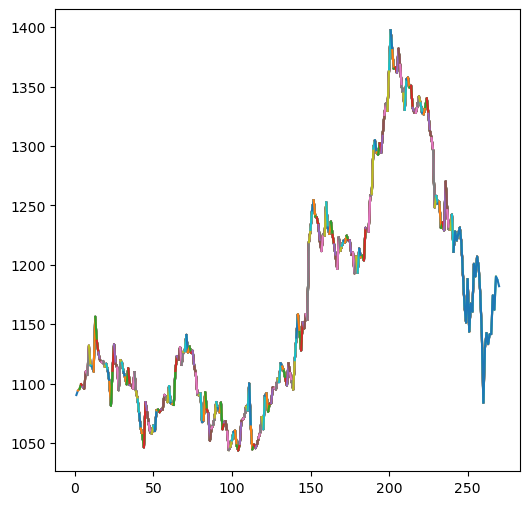

In [169]:
X_train = []
window_size = 30
for i in range(window_size, data.shape[0]):
    X_train.append(data["Close"][i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [171]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1796, 30, 30)


In [175]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, data["Close"].shape[0] - window_size):
    y_data.append(data["Close"][i] < data["Close"][i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_19564\3802898817.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(data["Close"][i] < data["Close"][i + window_size])


(1766,)

In [179]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1766, 30, 30)

In [181]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [203]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [205]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,489 (1.10 MB)

 Trainable params: 287,489 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [207]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.544144144144144, 1: 1.0}


In [209]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/50
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5139 - loss: 7.1476

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5118 - loss: 6.8909 - val_accuracy: 0.5904 - val_loss: 0.6701
Epoch 2/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4690 - loss: 1.0904

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4689 - loss: 1.0908 - val_accuracy: 0.6412 - val_loss: 0.6233
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5226 - loss: 1.0951 - val_accuracy: 0.6356 - val_loss: 0.6385
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5617 - loss: 1.0116 - val_accuracy: 0.4520 - val_loss: 0.7684
Epoch 5/50
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6272 - loss: 0.9637

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6242 - loss: 0.9650 - val_accuracy: 0.6582 - val_loss: 0.6472
Epoch 6/50
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6971 - loss: 0.8318

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6943 - loss: 0.8356 - val_accuracy: 0.6638 - val_loss: 0.6170
Epoch 7/50
39/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7312 - loss: 0.7674

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7291 - loss: 0.7689 - val_accuracy: 0.6695 - val_loss: 0.6587
Epoch 8/50
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7639 - loss: 0.6928

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7627 - loss: 0.6937 - val_accuracy: 0.6780 - val_loss: 0.6140
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7984 - loss: 0.6342 - val_accuracy: 0.6554 - val_loss: 0.7823
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8251 - loss: 0.5313 - val_accuracy: 0.6102 - val_loss: 1.0041
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8671 - loss: 0.4446 - val_accuracy: 0.6469 - val_loss: 0.8883
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8829 - loss: 0.4042 - val_accuracy: 0.6271 - val_loss: 1.0608
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8943 - loss: 0.3795 - val_accuracy: 0.5932 - val_loss: 1.0827
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9037 - loss: 0.3790 - val_accuracy: 0.6497 - val_loss: 1.1554
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9178 - loss: 0.2934 - val_accuracy: 0.6158 - val_loss: 1.1

In [210]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6491 - loss: 0.6699  
Accuracy over validation: 67.80%


Now, attempting the same for the differenced time series

(1130, 30)


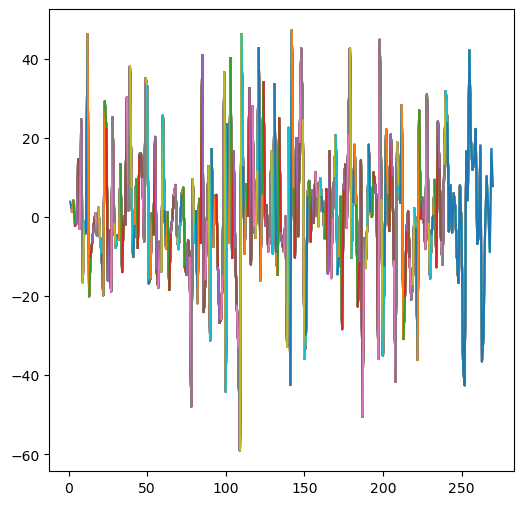

In [217]:
X_train = []
window_size = 30
for i in range(window_size, differenced_data.shape[0]):
    X_train.append(differenced_data["Close"][i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [219]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1130, 30, 30)


In [223]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, differenced_data["Close"].shape[0] - window_size):
    y_data.append(differenced_data["Close"][i] < differenced_data["Close"][i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_19564\2046321760.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(differenced_data["Close"][i] < differenced_data["Close"][i + window_size])


(1100,)

In [225]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1100, 30, 30)

In [227]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [229]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [231]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,489 (1.10 MB)

 Trainable params: 287,489 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [233]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.0952380952380953, 1: 1.0}


In [235]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/50
23/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5115 - loss: 12.0665

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5083 - loss: 10.5593 - val_accuracy: 0.5182 - val_loss: 0.7384
Epoch 2/50
22/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4695 - loss: 1.0798

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4732 - loss: 1.0785 - val_accuracy: 0.5227 - val_loss: 0.7238
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4897 - loss: 1.0253 - val_accuracy: 0.5227 - val_loss: 0.7005
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4897 - loss: 1.0502 - val_accuracy: 0.5227 - val_loss: 0.7307
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4810 - loss: 0.9992 - val_accuracy: 0.5227 - val_loss: 0.7216
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4832 - loss: 0.9738 - val_accuracy: 0.5227 - val_loss: 0.7445
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4958 - loss: 1.0117 - val_accuracy: 0.5136 - val_loss: 0.7430
Epoch 8/50
24/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4695 - loss: 1.0133

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4707 - loss: 1.0105 - val_accuracy: 0.5318 - val_loss: 0.7655
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5375 - loss: 1.0441 - val_accuracy: 0.5318 - val_loss: 0.7864
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5173 - loss: 1.0009 - val_accuracy: 0.5182 - val_loss: 0.7694
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4919 - loss: 0.9870 - val_accuracy: 0.5091 - val_loss: 1.0922
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5118 - loss: 1.0236 - val_accuracy: 0.5182 - val_loss: 0.7671
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5185 - loss: 0.9675 - val_accuracy: 0.5182 - val_loss: 0.8904
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5201 - loss: 0.9988 - val_accuracy: 0.5182 - val_loss: 0.8041
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5431 - loss: 0.9685 - val_accuracy: 0.5136 - val_lo

In [237]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5634 - loss: 0.7674  
Accuracy over validation: 53.18%


Now for the fractionally Differenced Series

(1786, 30)


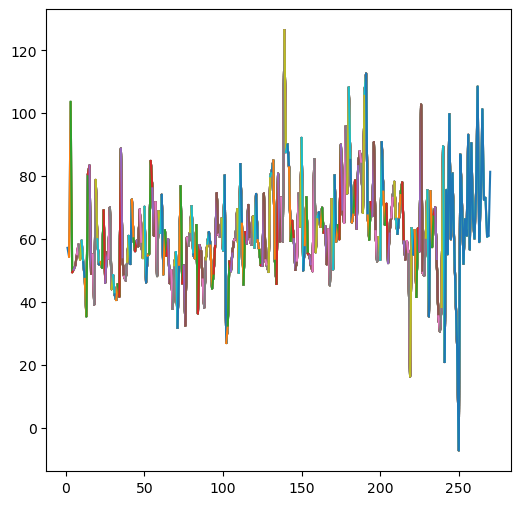

In [246]:
X_train = []
window_size = 30
for i in range(window_size, frac_diff_series.shape[0]):
    X_train.append(frac_diff_series["Close"][i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [248]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1786, 30, 30)


In [250]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, frac_diff_series["Close"].shape[0] - window_size):
    y_data.append(frac_diff_series["Close"][i] < frac_diff_series["Close"][i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_19564\146870747.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(frac_diff_series["Close"][i] < frac_diff_series["Close"][i + window_size])


(1756,)

In [252]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1756, 30, 30)

In [254]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [256]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [258]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,489 (1.10 MB)

 Trainable params: 287,489 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [260]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.1402439024390243, 1: 1.0}


In [262]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/50
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4803 - loss: 14.1308

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4802 - loss: 12.7144 - val_accuracy: 0.4915 - val_loss: 0.7108
Epoch 2/50
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4924 - loss: 1.1409

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4918 - loss: 1.1367 - val_accuracy: 0.5199 - val_loss: 0.7077
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4741 - loss: 1.0463 - val_accuracy: 0.5170 - val_loss: 0.7074
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4542 - loss: 1.0270 - val_accuracy: 0.4744 - val_loss: 0.7167
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4704 - loss: 1.0398 - val_accuracy: 0.5170 - val_loss: 0.7266
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4654 - loss: 0.9947 - val_accuracy: 0.5142 - val_loss: 0.7260
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4599 - loss: 1.0398 - val_accuracy: 0.5085 - val_loss: 0.7366
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4733 - loss: 1.0116 - val_accuracy: 0.5199 - val_loss: 0.7287
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4518 - loss: 1.1084 - val_accuracy: 0.5170 - val_loss: 0.

In [264]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5218 - loss: 0.7083  
Accuracy over validation: 51.99%
